In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import torch
from fastai.text import *
from pathlib import Path
import dill as pickle

DATA = Path('../data/')
LM = DATA/'language-model/'
WT = DATA/'wt/models/wt103/'
TMP = DATA/'tmp'

### 1. Load WikiText Embeddings

In [8]:
# Config
em_sz, nh, nl = 400, 1150, 3

In [9]:
# Load vocab
wt_itos = pickle.load((WT/'itos_wt103.pkl').open('rb'))
wt_stoi = collections.defaultdict(lambda:-1, {tok:i for i,tok in enumerate(wt_itos)})

# Get wikitext encoder weights
wgts = torch.load(WT/'fwd_wt103.h5', map_location=lambda storage, loc: storage)
enc_wgts = to_np(wgts['0.encoder.weight'])
mean_wgts = enc_wgts.mean(0)
  
# Map quora vocab to wikitext weights
quora_wgts = np.zeros((vs, em_sz), dtype=np.float32)
miss = []
for i, tok in enumerate(itos):
    mpidx = wt_stoi[tok]
    if mpidx != -1:
        quora_wgts[i] = enc_wgts[mpidx]
    else:
        quora_wgts[i] = mean_wgts
        miss.append(tok)
        
print(f"Total missing: {len(miss)}/{vs}")

Total missing: 15750/60002


In [10]:
# Modify current encoder weights
wgts['0.encoder.weight'] = T(quora_wgts)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(quora_wgts))
wgts['1.decoder.weight'] = T(np.copy(quora_wgts))

### 2. Load Language Model

In [11]:
# Config
wd = 1e-7
bptt = 70
bs = 48
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

# Dropout
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

# Load LM tokens
lm_trn = np.load(LM/'lm_trn.npy')
lm_val = np.load(LM/'lm_val.npy')

# Dataloaders
lm_trn_dl = LanguageModelLoader(np.concatenate(lm_trn).astype(np.int64), bs, bptt)
lm_val_dl = LanguageModelLoader(np.concatenate(lm_val).astype(np.int64), bs, bptt)
md = LanguageModelData(DATA/'tmp', 1, vs, lm_trn_dl, lm_val_dl, bs=bs, bptt=bptt)

# Learner
ft_encoder= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

ft_encoder.metrics = [accuracy]
ft_encoder.model.load_state_dict(wgts)

#####  Finetune last layer

In [ ]:
ft_encoder.freeze_all_but(-1)

wd=1e-9
ft_encoder.lr_find(1e-5, end_lr=2, linear=True, wds=wd)

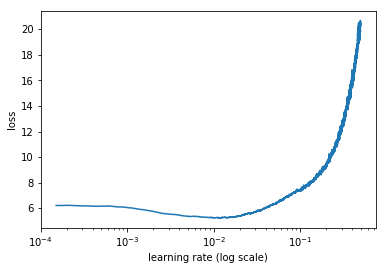

In [25]:
ft_encoder.sched.plot()

In [15]:
wd=1e-9
lrs=1e-3
ft_encoder.fit(lrs, 1, wds=wd, use_clr=(30,10), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                             
    0      4.171768   3.985831   0.362855  



[array([3.98583]), 0.3628553550554766]

In [16]:
ft_encoder.save('lm_last_ft')

##### Finetune rest of the model

In [21]:
ft_encoder.load('lm_last_ft')

In [15]:
ft_encoder.unfreeze()

In [19]:
wd=1e-9
ft_encoder.lr_find(1e-6, end_lr=2, linear=True, wds=wd)

  6%|▌         | 7382/132358 [14:26<4:04:26,  8.52it/s, loss=16.8]

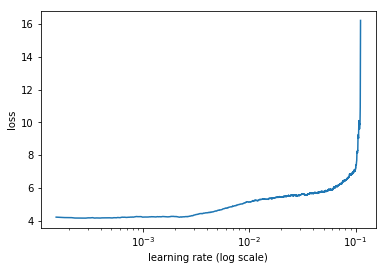

In [21]:
ft_encoder.sched.plot()

In [ ]:
wd=1e-9
lrs=1e-4
ft_encoder.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=1)
# ft_encoder.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

In [33]:
ft_encoder.save('lm1')

In [34]:
ft_encoder.save_encoder('lm1_enc')